# Analyzing A/B Test Results of an e-commerce website

This project was part of the Data Analyst NanoDegree program offere on Udacity. The idea is to apply the statistical skills I acquired and showcase them here, in a practical project. 

## Table of Contents

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

I will use this part to showcase my understanding of probability.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#I am setting the seed to assure I comply with the same answers of Udacity
random.seed(42)

In [2]:
# Dataset import and minimal datset exploration
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
print(df.shape)
print(df['user_id'].nunique())

(294478, 5)
290584


Firstly I calculate the proportion of the users converted:

In [5]:
#Note that I use nunique(), as I need to count the DISTINCT users that converted
df.query('converted == "1"').user_id.nunique() / df['user_id'].nunique()


0.12104245244060237

The number of times the new_page and treatment don't line up:

In [7]:
a_mismatch = df.query('group == "control" and landing_page =="new_page"' )
b_mismatch = df.query('group == "treatment" and landing_page =="old_page"' )

a_mismatch.shape[0] + b_mismatch.shape[0]

3893

In [8]:
#Do we have any missing values? Apparently no.
df[df.isnull().any(axis=1)]

,user_id,timestamp,group,landing_page,converted


For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. Use Quiz 2 in the classroom to provide how we should handle these rows.

a. Now I have to create two different df because of the mismatches.

In [9]:
df1 = df.drop(a_mismatch.index)
df2 = df1.drop(b_mismatch.index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
df2['user_id'].nunique()

290584

In [19]:
df2.shape[0]

290584

In [15]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
df2 = df2.drop_duplicates(subset='user_id')
df2.shape[0]

290584

What is the probability of an individual converting regardless of the page they receive?

In [25]:
df2.query('converted == "1"').user_id.nunique() / df2['user_id'].nunique()

0.11959708724499628

Given that an individual was in the control group, what is the probability they converted?

In [21]:
p_conv_ctrl = df2.query('converted == "1" and group == "control"').user_id.nunique() / df2.query('group == "control"').user_id.nunique()
p_conv_ctrl

0.1203863045004612

Given that an individual was in the treatment group, what is the probability they converted?

In [22]:
p_conv_treat = df2.query('converted == "1" and group == "treatment"').user_id.nunique() / df2.query('group == "treatment"').user_id.nunique()
p_conv_treat 

0.11880806551510564

In [23]:
p_conv_treat - p_conv_ctrl # !! Keep in mind that later, under the null, we are assuming this difference to be 0 anyways.

-0.0015782389853555567

What is the probability that an individual received the new page?

In [24]:
df2.query('landing_page == "new_page"').user_id.nunique() / df2.shape[0]

0.5000619442226688

#### What can we conclude at this point?
Not much really. The control group obtained slightly higher conversions than treatment group. However, not only the difference is minimal, but also **we did not run any statistical test in order to substantiate our findings (no p- value, no z-tests calculated).**

<a id='ab_test'></a>
### Part II - A/B Test
f I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{null}: p_{old} - p_{new} \leq 0$**   <br>
**$H_{alt}: p_{new} - p_{old} > 0$**

The Hypothesis that we want to reject is that, on average, the conversion rate of the old page is better or equal to the new page. This is our starting point and what we are trying to disprove. 
Conversely, the alternative Hypothesis is that, on average, the conversion rate of the new page is better than the old page. 
It is also important to keep in mind the standard 0.05 threshold for the statistical significance.

**Now I will ask a few questions to show the typical way of reasoning in this situations.**

a. What is the convert rate for  pnew  under the null?

In [27]:
# As the null Hp states that on average the conversion rate of Pold will be greater or equal to the Pnew,
# what is the highest possible value that Pnew can have under the null? Pnew = Pold . 
# So I set p_new equal to the mean 
p_new = df2.converted.mean()
p_new
# I have to assume not only that Pnew and Pold are equal, 
# but also that they are equal to the converted rate in ab_data.csv regardless of the page.
# I should make sense now given the assumptions stated.

0.11959708724499628

b. What is the convert rate for  pold  under the null?

In [28]:
# ..consequently:
p_old = df2.converted.mean()
p_old
# Pold = Pnew is basically the farthermost level at which the Null Hp stands true.

0.11959708724499628

c. What is the sample of Pnew (n_new) ?

In [29]:
# If I calculated things correctly, there should be only unique user_ids per each group/landing_page,
# So I can go this way..
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is  n_old ?

In [63]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate  n_new  transactions with a convert rate of  p_new  under the null. Store these  n_new  1's and 0's in new_page_converted.

In [64]:
# Here I simulate n_new transactions
# I am recalculating the sample basically. I compute the p_new probability to get converted (1 means conversion
# 0 means no conversion), n_new times.
new_page_converted = []
for _ in range(n_new):
    a = np.random.binomial(1, p_new)
    new_page_converted.append(a)
    
new_page_converted = np.asarray(new_page_converted)

f. Simulate  nold  transactions with a convert rate of  pold  under the null. Store these  nold  1's and 0's in old_page_converted.

In [69]:
# Same for n_old
old_page_converted = []
for _ in range(n_old):
    b = np.random.binomial(1, p_old)
    old_page_converted.append(b)
    
old_page_converted = np.asarray(old_page_converted)

g. Find  pnew  -  pold  for your simulated values from part (e) and (f).

In [70]:
sim_pnew_minus_pold = (new_page_converted.mean() - old_page_converted.mean())
sim_pnew_minus_pold

0.0017048227728868326

h. Simulate 10,000  pnew  -  pold  values using this same process similarly to the one you calculated in parts a. through g. above. Store all 10,000 values in p_diffs.

In [73]:
# This is bootstrap sampling
# I could nest for loops but this is probably faster.
p_diffs = []
for _ in range(10000):
    bs_new_page_c = np.random.binomial(1, p_new, n_new)
    bs_old_page_c = np.random.binomial(1, p_old, n_old)
    p_diffs.append(bs_new_page_c.mean()-bs_old_page_c.mean())

Plot a histogram of the p_diffs.

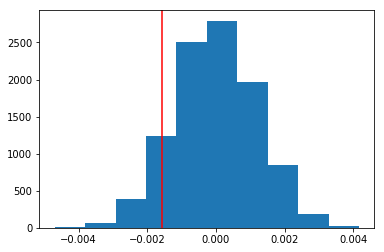

In [74]:
actual_diff = p_conv_treat - p_conv_ctrl
plt.hist(p_diffs)
plt.axvline(actual_diff, c='red');

j. What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

In [76]:
# Calculating the p-value here.
# I have to turn p_diffs to an array, if I do the following with p_diffs as a list, it won't work.
p_diffs = np.asarray(p_diffs)
(p_diffs > actual_diff).mean() #In how many cases the calculated differences (from the simulations) were higher than the actual differences?

0.90429999999999999

**Slightly over 90% of the proportional differences we calculated in our simulation was greater than the actual difference (marked by the red line). In other words, we wanted to compute, under our null hypothesis, the probability of seeing a difference in conversions as extreme or more extreme than the actual difference. This is actually the p-value of our study, which states that in 90% of the cases we would see results as extreme or more extreme than the actual differences. When we started, we had set a p-value of 0.05, which implies that we have to consider this result, not statistically significant.**

We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [77]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').user_id.nunique()  #  we had this from part I Q4.
convert_new = df2.query('group == "treatment" and converted == 1').user_id.nunique() # this one too.
n_old = df2.query('group == "control"').user_id.nunique()
n_new = df2.query('group == "treatment"').user_id.nunique()

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now we use stats.proportions_ztest to compute the test statistic and p-value.

In [79]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

Here I have to watch out! why does the p-value of the built in disagrees with what we have calculated?

In [80]:
# The p-value above has not been calculated correctly given the specific conditions of our research!!
# Above, the p-value was calculated as both tails of the distribution were to be considered, but we should
# remember that the Null Hp was not Pnew = Pold, but Pold >= Pnew. This means we need only one tail.
one_tail = p_value/2
one_tail

0.094941687240975514

In [81]:
1- one_tail

0.90505831275902449

We should recall that our investigation is "one tailed". In other words, we have a null Hp that states "p_new - p_old <= 0, rather than "p_new - p_old = 0". The built in function is more compatible with a two-tailed Hypothesis test. In such test the null Hp could be stated in this fashion: p_new - pold = 0 and the alternative Hp being $p{new} - p_{old} \neq 0$ . Therefore we should half the calculated p-value to get the result we want. I also included a subtraction of the resulting value from 1, to see how close it gets to the value we originally calculated in question j.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will show that the result acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should I be performing in this case?

Logistic.

b. The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [82]:
df2['intercept'] = 1
df2[['old_page', 'new_page']] = pd.get_dummies(df2['landing_page'])
df2.head() # I needed two passages to create the ab_page, although I see it's just what I labeled old_page

,user_id,timestamp,group,landing_page,converted,intercept,old_page,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [83]:
df2['ab_page'] = df2['old_page']
df2 = df2.drop(['old_page', 'new_page'], axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use statsmodels to import your regression model. Instantiate the model, and fit the model using the two columns you created in part b. to predict whether or not an individual converts.

In [84]:
# I have inserted the lamba func as the code was not working
# I found the solution here https://github.com/statsmodels/statsmodels/issues/3931
# I also asked the mentor, it's because of chisqprob deprecation.
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [85]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Apr 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:00:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with ab_page? Why does it differ from the value I found in the Part II?

Hint: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the Part II?

The p-value associated with ab_page is 0.190, the double of the one we calculated in part II. 

The null and alternative hypothesis in the regression model are as follows: <br>
HO :  pnew  -  pold=0  

HA :  pnew  -  pold≠0  

**The difference with our alternative and null Hypothesis stated in Part II is clear: The analysis of the regression model implies a two-tailed test. Our prior investigation was one-tailed.**

f. Now, why it is a good idea to consider other factors to add into your regression model? Are there any disadvantages to adding additional terms into your regression model?

The first disadvantgage of adding new features is the increased probability in collinearity. New features can also impact the significance of the analysis, deflating our p-value. However, adding new features can show new correlations, which in turn can give us more insight on what can help us improve our conversions, the point, once again, is how the statistical tests will behave after the inclusion of the new features.

g. Now along with testing if the conversion rate changes for different pages, I also add an effect based on which country a user lives. I will need to read in the countries.csv dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion?

In [86]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [87]:
df_new.country.unique() # As the description states: 3 countries.

array(['UK', 'US', 'CA'], dtype=object)

In [88]:
### Create the necessary dummy variables, assigning the proper labels.
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0,0,0,1
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0,0,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1,1,0,0
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0,0,1,0


In [89]:
# Dropping UK so it can be our baseline
logit_mod = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Apr 2018   Pseudo R-squ.:               2.323e-05
Time:                        16:06:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

In [90]:
np.exp(-0.0099), np.exp(-0.0506) 
#Here is in "unit increase", though the value is below 1... However, I find it more intuitive this way, without calculating the reciprocal
#If an individual lives in the US, it is 0.99 times as likely to convert than the baseline (UK).
#If an individual lives in Canada, it is 0.95 times as likely to convert than the baseline (UK).

(0.99014884368295719, 0.95065885803307082)

In [91]:
np.exp(results.params) 

intercept    0.138154
ab_page      0.985168
US           0.990165
CA           0.950621
dtype: float64

Firstly we should restate one more time that this model implies a two tailed Hp test: 

pnew−pold=0  and the alternative Hp being:  pnew−pold≠0  

Under these conditions, the Logit regressions results still tell us that there is no significance at 0.05 threshold.

Yet, if we were to assume these results as significant, we would conclude the following: 
If an individual lives in the US, it is 0.99 times as likely to convert than the baseline (UK).
If an individual lives in Canada, it is 0.95 times as likely to convert than the baseline (UK).
If an individual sees the new page, it is 0.985 times as likely to convert holding everything else equal.

Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion. I'll create the necessary additional columns, and fit the new model.

In [92]:
# We are creating new columns to further categorize the data.
# e.g. a user from Canada that views the old page will have a CA_ab value of 0, a user from US, new page, US_ab 1
# This granular view will allow us to see if there are interaction between specific countries and the 2 page variants
df_new['US_ab'] = np.multiply(df_new['ab_page'],df_new['US'])
df_new['CA_ab'] = np.multiply(df_new['ab_page'],df_new['CA'])
df_new['UK_ab'] = np.multiply(df_new['ab_page'],df_new['UK'])

df_new.head(10)


,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,US_ab,CA_ab,UK_ab
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0,1
909908,UK,2017-01-06 20:44:26.334764,treatment,new_page,0,1,1,0,1,0,0,0,1
811617,US,2017-01-02 18:42:11.851370,treatment,new_page,1,1,1,0,0,1,1,0,0
938122,US,2017-01-10 09:32:08.222716,treatment,new_page,1,1,1,0,0,1,1,0,0
887018,US,2017-01-06 11:09:40.487196,treatment,new_page,0,1,1,0,0,1,1,0,0


In [93]:
logit_mod = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','CA','US_ab','CA_ab']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 26 Apr 2018   Pseudo R-squ.:               3.482e-05
Time:                        16:09:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_ab         -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_ab         -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

In [96]:
1/np.exp(-0.0783), 1/np.exp(-0.0314), 1/np.exp(-0.0118), 1/np.exp(0.0057)

(1.0814470441230692, 1.0318981806179213, 1.011869894648401, 0.9943162141784333)

In [95]:
np.exp(results.params)

intercept    0.136392
ab_page      1.010893
US           1.005761
CA           0.988285
US_ab        0.969090
CA_ab        0.924703
dtype: float64

There are no significant effects on conversions. Yet, if we were to assume these results as significant, we would conclude the following: 
If an individual lives in the US and sees the new page, it is 0.97 times as likely to convert than the baseline (UK).
If an individual lives in Canada and sees the new page, it is 0.92 times as likely to convert than the baseline (UK).

# Conclusions

After going through the analysis, there are a few points we should highlight. Firstly, the practical significance of the change is minimal. In other words, even if the test results were highly significant, changing to a new page would not have that big of an impact on conversions. Moreover, as we saw, there is no sufficient support to our alternative hypothesis in the first place. This does not necessarily mean the new page is bad. In fact, we do not know for how much time the A/B test has been running, and when the page change was implemented. As we studied in the lectures, an increased sample size (more time spent A/B-testing) will tend to increase the significance of our study. Moreover, from the practical point of view, it might well be that the users need time to adjust to the new page (novelty effect), which in the long run could perform better than the old one.


